# Косенко Никита М24-514
## Лабораторная работа №3, вариант 6

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KernelDensity, KNeighborsRegressor

Подключаем данные

In [67]:
data = pd.read_csv('data_ml_v3-06.csv')
data.head()
# print(data.shape)

,x,y
0,-0.60604,-1.179300
1,-0.35888,-2.347900
2,-2.05920,1.811500
3,-1.04380,1.678300
4,-1.11560,-0.018185


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       300 non-null    float64
 1   y       300 non-null    float64
dtypes: float64(2)
memory usage: 4.8 KB


In [69]:
train_data, temp_data = train_test_split(data, test_size=0.4, random_state=42)

# Второе разбиение: 30% validation и 10% test от исходных данных
val_data, test_data = train_test_split(temp_data, test_size=0.25, random_state=42)

print(f"Обучающая выборка: {len(train_data)} записей ({len(train_data)/len(data)*100:.1f}%)")
print(f"Валидационная выборка: {len(val_data)} записей ({len(val_data)/len(data)*100:.1f}%)")
print(f"Тестовая выборка: {len(test_data)} записей ({len(test_data)/len(data)*100:.1f}%)")

Обучающая выборка: 180 записей (60.0%)
Валидационная выборка: 90 записей (30.0%)
Тестовая выборка: 30 записей (10.0%)


Чисто посмотреть, что за данные.

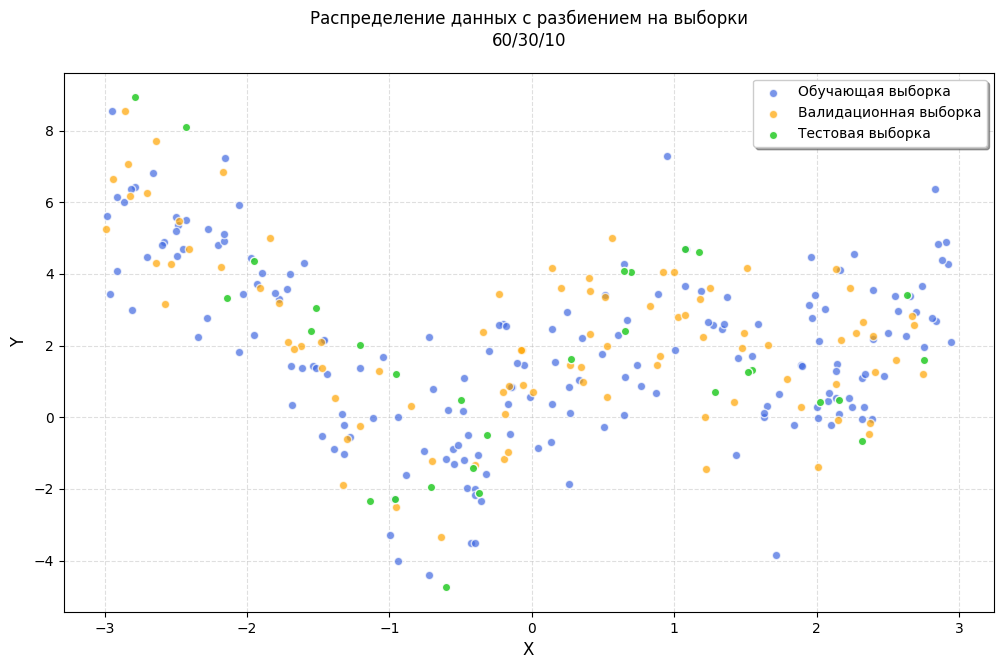

In [70]:
plt.figure(figsize=(12, 7))

# Обучающая выборка
plt.scatter(train_data.iloc[:, 0], train_data.iloc[:, 1],
            c='royalblue', alpha=0.7, edgecolor='w',
            label='Обучающая выборка', zorder=2)

# Валидационная выборка
plt.scatter(val_data.iloc[:, 0], val_data.iloc[:, 1],
            c='orange', alpha=0.7, edgecolor='w',
            label='Валидационная выборка', zorder=2)

# Тестовая выборка
plt.scatter(test_data.iloc[:, 0], test_data.iloc[:, 1],
            c='limegreen', alpha=0.9, edgecolor='w',
            label='Тестовая выборка', zorder=3)

plt.title('Распределение данных с разбиением на выборки\n60/30/10', pad=20)
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.grid(linestyle='--', alpha=0.4)
plt.legend(loc='best', frameon=True, shadow=True)

plt.show()

### Задание 1
Построить регрессограммы для различного числа интервалов группировки:

а) 3

б) 10

в) 50

In [ ]:
def fit_bin_regression(train_df, n_bins):
    bins = pd.cut(train_df.iloc[:, 0], bins=n_bins)
    bin_edges = bins.cat.categories.right.to_numpy()
    bin_means = train_df.groupby(bins, observed=False)[train_df.columns[1]].mean()
    
    return bin_means, bin_edges

In [ ]:
def predict_bin_regression(x_values, bin_means, bin_edges):
    bin_indices = np.digitize(x_values, bin_edges, right=False) - 1
    bin_indices = np.clip(bin_indices, 0, len(bin_means)-1)
    
    return bin_means.iloc[bin_indices].values

In [ ]:
def plot_regression(data, n_bins, color, title):
    bin_means, bin_edges = fit_bin_regression(data, n_bins)
    
    x_grid = np.linspace(data.iloc[:,0].min(), data.iloc[:,0].max(), 1000)
    y_pred = predict_bin_regression(x_grid, bin_means, bin_edges)
    
    plt.scatter(data.iloc[:,0], data.iloc[:,1], 
                alpha=0.3, color='royalblue', label='Данные')
    plt.plot(x_grid, y_pred, color=color, 
             linewidth=2, label='Предсказание')
    
    # Разметка границ бинов
    for edge in bin_edges:
        plt.axvline(edge, color='gray', linestyle='--', alpha=0.5)
    
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(alpha=0.3)
    plt.legend()

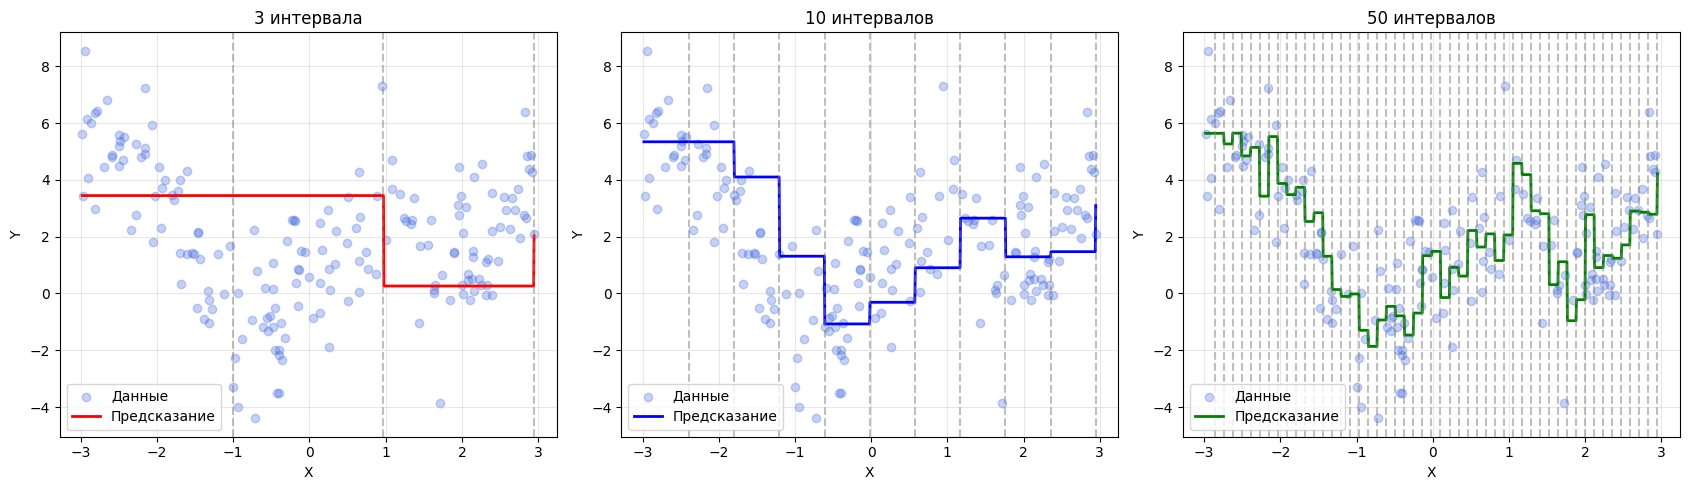

In [95]:
plt.figure(figsize=(17, 5))

# Для 3 интервалов
plt.subplot(1, 3, 1)
plot_regression(train_data, 3, 'red', '3 интервала')

# Для 10 интервалов
plt.subplot(1, 3, 2)
plot_regression(train_data, 10, 'blue', '10 интервалов')

# Для 50 интервалов
plt.subplot(1, 3, 3)
plot_regression(train_data, 50, 'green', '50 интервалов')

plt.tight_layout()
plt.show()

Построить график зависимости MSE непараметрической регрессии на обучающей, 
валидационной и тестовой выборках от числа интервалов группировки. Разбиение на обучающую, валидационную и тестовую выборки – holdout в отношении 60/30/10.

In [ ]:
bins_range = [3, 10, 20, 30, 40, 50]  # Диапазон интервалов
results = []

for n_bins in bins_range:
    bin_means, bin_edges = fit_bin_regression(train_data, n_bins)
    
    # Расчет MSE для всех выборок
    for data_name, dataset in [('train', train_data), 
                              ('val', val_data), 
                              ('test', test_data)]:
        x = dataset.iloc[:, 0].values
        y_true = dataset.iloc[:, 1].values
        y_pred = predict_bin_regression(x, bin_means, bin_edges)
        
        mse = mean_squared_error(y_true, y_pred)
        results.append({
            'n_bins': n_bins,
            'dataset': data_name,
            'mse': mse
        })

In [78]:
df_results = pd.DataFrame(results)
pivot_results = df_results.pivot(index='n_bins', columns='dataset', values='mse')

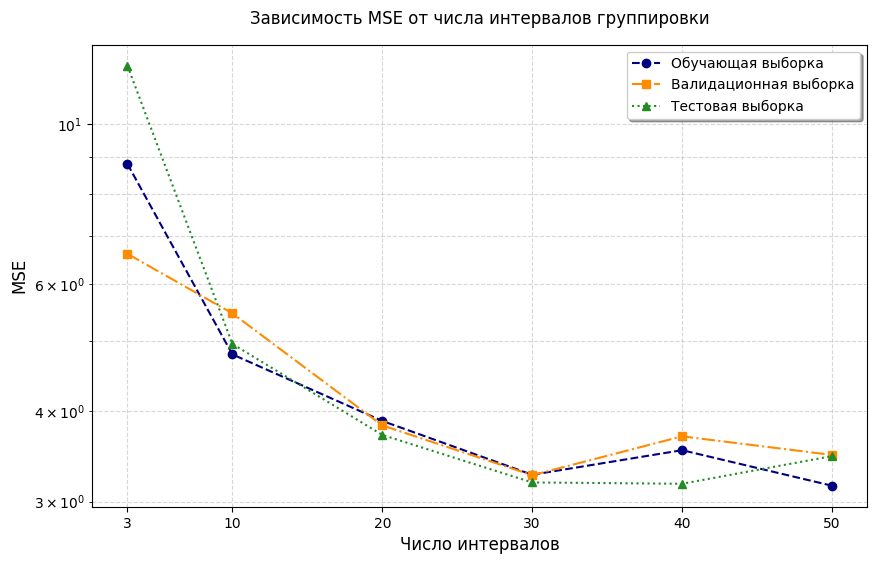

In [79]:
plt.figure(figsize=(10, 6))

# Графики для каждой выборки
plt.plot(pivot_results.index, pivot_results['train'], 
         marker='o', linestyle='--', 
         label='Обучающая выборка', color='navy')

plt.plot(pivot_results.index, pivot_results['val'], 
         marker='s', linestyle='-.', 
         label='Валидационная выборка', color='darkorange')

plt.plot(pivot_results.index, pivot_results['test'], 
         marker='^', linestyle=':', 
         label='Тестовая выборка', color='forestgreen')

# Настройки отображения
plt.title('Зависимость MSE от числа интервалов группировки', pad=15)
plt.xlabel('Число интервалов', fontsize=12)
plt.ylabel('MSE', fontsize=12)
# plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.xticks(bins_range, labels=bins_range)
plt.legend(frameon=True, shadow=True, loc='upper right')

plt.show()

### Задание 2
Построить графики зависимости MSE ядерной регрессии на обучающей, валидационной и тестовой выборках от ширины окна для:

а) прямоугольного окна:
$$
K(u) =
\begin{cases}
\frac{1}{2},& \quad |u| < 1\\
0 & \quad \text{otherwise}
\end{cases}
$$    


б) гауссова окна:
$$
K(u) = \frac{1}{\sqrt{2\pi}} exp(- \frac{u^2}{2})
$$ 

в) окна  Епанечникова:
$$
K(u) = 
\begin{cases}
\frac{3}{4}(1 - u^2),& \quad |u| < 1\\
0 & \quad \text{otherwise}
\end{cases}
$$

г) треугольного окна:
$$
K(u) = 
\begin{cases}
1 - |u|,& \quad |u| < 1\\
0 & \quad \text{otherwise}
\end{cases}
$$

Определить оптимальную ширину каждого окна. Оптимальные  значения гиперпараметров обучения определять по значению 
ошибки на валидационной выборке.

In [ ]:
# Ядра
def kernel_function(u, kernel_type):
    u = np.abs(u)
    if kernel_type == 'rectangular':
        return np.where(u <= 1, 0.5, 0)
    elif kernel_type == 'gaussian':
        return np.exp(-0.5 * u**2) / np.sqrt(2*np.pi)
    elif kernel_type == 'epanechnikov':
        return np.where(u <= 1, 0.75*(1 - u**2), 0)
    elif kernel_type == 'triangular':
        return np.where(u <= 1, (1 - u), 0)
    else:
        raise ValueError("Unknown kernel type")

In [81]:
def kernel_regression(x_train, y_train, x_test, h, kernel_type):
    y_pred = []
    for x in x_test:
        weights = kernel_function((x - x_train)/h, kernel_type)
        weights_sum = np.sum(weights)
        if weights_sum == 0:
            y_pred.append(np.mean(y_train))
        else:
            y_pred.append(np.sum(weights * y_train) / weights_sum)
    return np.array(y_pred)

In [82]:
def calc_mse_with_kernel(data, h, kernel):
    y_pred = kernel_regression(
        train_data.iloc[:,0].values,
        train_data.iloc[:,1].values,
        data.iloc[:, 0].values,
        h, kernel
    )

    mse = mean_squared_error(data.iloc[:, 1], y_pred)
    return mse
    

In [83]:
kernels = ['rectangular', 'gaussian', 'epanechnikov', 'triangular']
h_range = np.logspace(-2, 1, 50)  # Диапазон ширины окна
results = []

for kernel in kernels:
    for h in h_range:
        mse_train = calc_mse_with_kernel(train_data, h, kernel)
        mse_val = calc_mse_with_kernel(val_data, h, kernel)
        mse_test = calc_mse_with_kernel(test_data, h, kernel)
        
        results.append({
            'kernel': kernel,
            'h': h,
            'train_mse': mse_train,
            'val_mse': mse_val,
            'test_mse': mse_test
        })

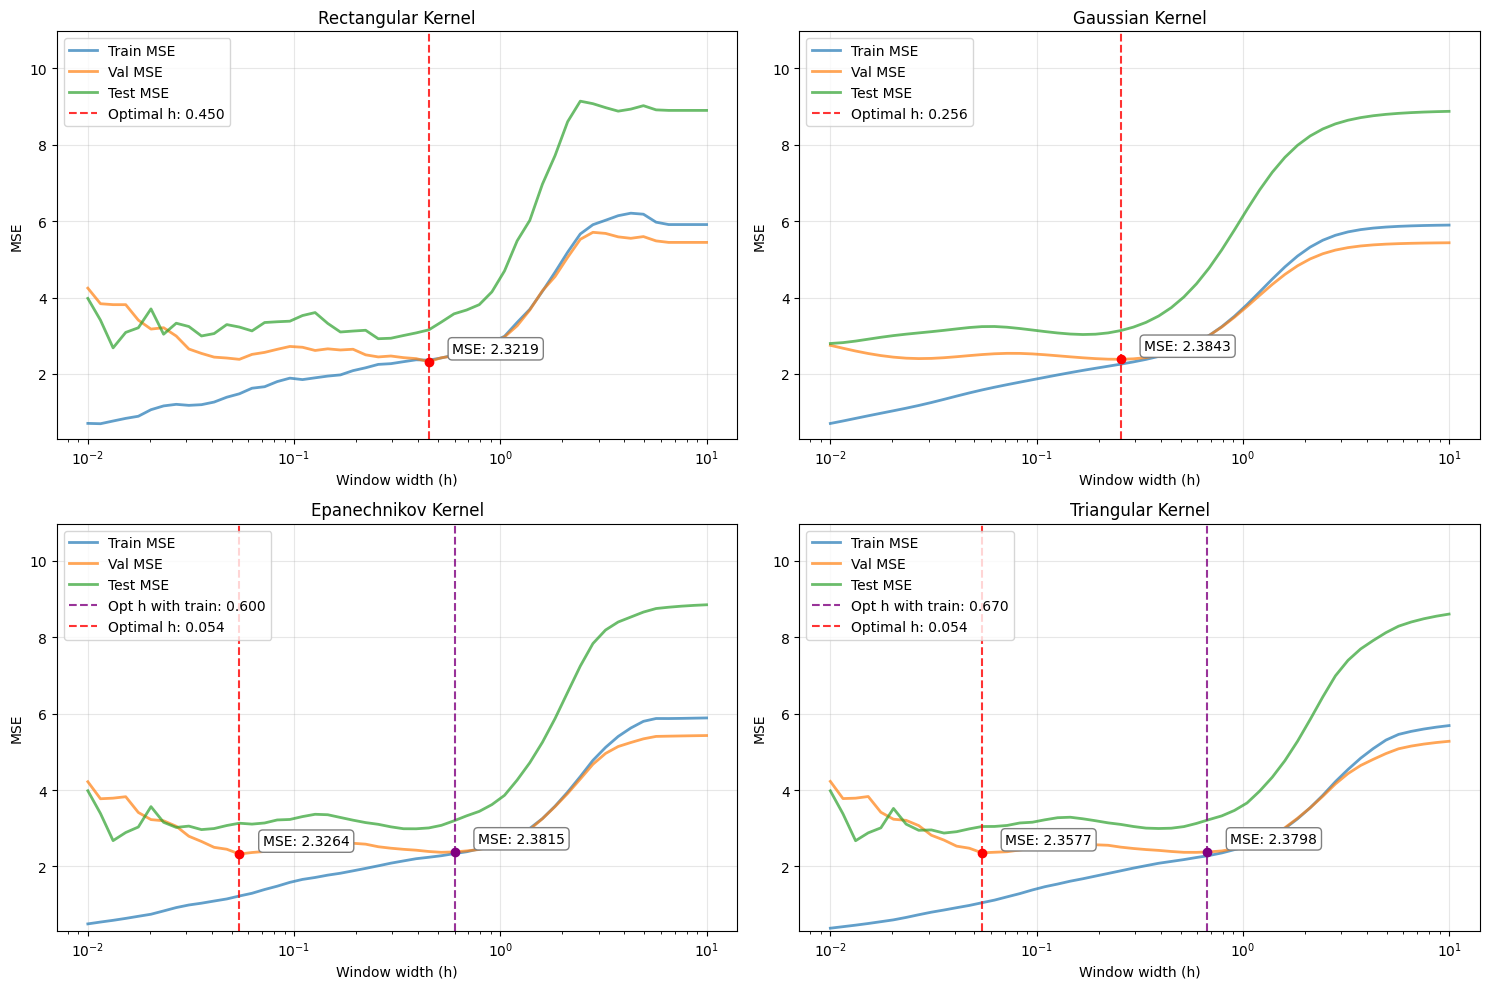

In [ ]:
df_results = pd.DataFrame(results)
plt.figure(figsize=(15, 10))
global_y_min = df_results[['train_mse', 'val_mse', 'test_mse']].min().min() * 0.8
global_y_max = df_results[['train_mse', 'val_mse', 'test_mse']].max().max() * 1.2

for i, kernel in enumerate(kernels, 1):
    plt.subplot(2, 2, i)
    subset = df_results[df_results['kernel'] == kernel]
    
    # Основные графики
    plt.plot(subset['h'], subset['train_mse'], label='Train MSE', lw=2, alpha=0.7)
    plt.plot(subset['h'], subset['val_mse'], label='Val MSE', lw=2, alpha=0.7)
    plt.plot(subset['h'], subset['test_mse'], label='Test MSE', lw=2, alpha=0.7)
    
    # оптимальные значения
    optimal_row = subset.loc[subset['val_mse'].idxmin()]
    optimal_h = optimal_row['h']
    optimal_mse = optimal_row['val_mse']

    plt.scatter(optimal_h, optimal_mse, color='red', zorder=5)
    plt.annotate(
    f'MSE: {optimal_mse:.4f}',
    xy=(optimal_h, optimal_mse),
    xytext=(optimal_h*1.3, optimal_mse*1.1),
    bbox=dict(boxstyle="round", fc="white", ec="gray")
    )

    if kernel == 'epanechnikov':
        h = 0.6
        err = calc_mse_with_kernel(val_data, h, kernel)
        plt.scatter(h, err, color='purple', zorder=5)
        plt.annotate(
            f'MSE: {err:.4f}',
            xy=(h, err),
            xytext=(h*1.3, err*1.1),
            bbox=dict(boxstyle="round", fc="white", ec="gray")
        )

        plt.axvline(h, color='purple', linestyle='--', 
                linewidth=1.5, alpha=0.8, label=f'Opt h with train: {h:.3f}')
    if kernel == 'triangular':
        h = 0.67
        err = calc_mse_with_kernel(val_data, h, kernel)
        plt.scatter(h, err, color='purple', zorder=5)
        plt.annotate(
            f'MSE: {err:.4f}',
            xy=(h, err),
            xytext=(h*1.3, err*1.1),
            bbox=dict(boxstyle="round", fc="white", ec="gray")
        )

        plt.axvline(h, color='purple', linestyle='--', 
                linewidth=1.5, alpha=0.8, label=f'Opt h with train: {h:.3f}') 
    
    plt.axvline(optimal_h, color='red', linestyle='--', 
                linewidth=1.5, alpha=0.8, label=f'Optimal h: {optimal_h:.3f}')
                
    plt.xscale('log')
    # plt.yscale('log')
    plt.ylim(global_y_min, global_y_max)
    plt.title(f'{kernel.capitalize()} Kernel')
    plt.xlabel('Window width (h)')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Выводы
Если при выборе оптимального размера окна опираться только на значение MSE на валидационной выборе, то получаем следующие результаты:
1. Для прямоугольного окна оптимальная ширина окна h = 0.45 при MSE = 2.3219
2. Для гауссова окна оптимальная ширина окна h = 0.256 при MSE = 2.3843
3. Для окна Епанечникова оптимальная ширина окна h = 0.054 при MSE = 2.3264
4. Для треугольного окна оптимальная ширина окна h = 0.054 при MSE = 2.3577

При этом расхождения в MSE в случаях прямоугольного и гауссова окна для обучающей и валидационной выборок незначительны. В случаях же окна Епанечникова и треугольного окна можно найти (визуально) еще одно примерно такое же оптимальное значение размера окна, но в месте, где расхождение MSE у обучающей и валидационной выборок будет меньше.

Конкретно для данного датасета есть следующие результаты:
1. Для окна Епанечникова оптимальная ширина окна с учетом расхождения MSE h = 0.6 при MSE = 2.3815
2. Для треугольного окна оптимальная ширина окна с учетом расхождения MSE h = 0.67 при MSE = 2.3798


### Задание 3
Визуализировать графики ядерной функции регрессии, полученной с использованием каждого вида окна из задания 2.

Ширину окна  задать:

i)  равной  соответствующему  оптимальному  значению,  полученному  в задании 2

ii) значению, меньшему оптимального

iii) значению, большему оптимального

Поскольку 

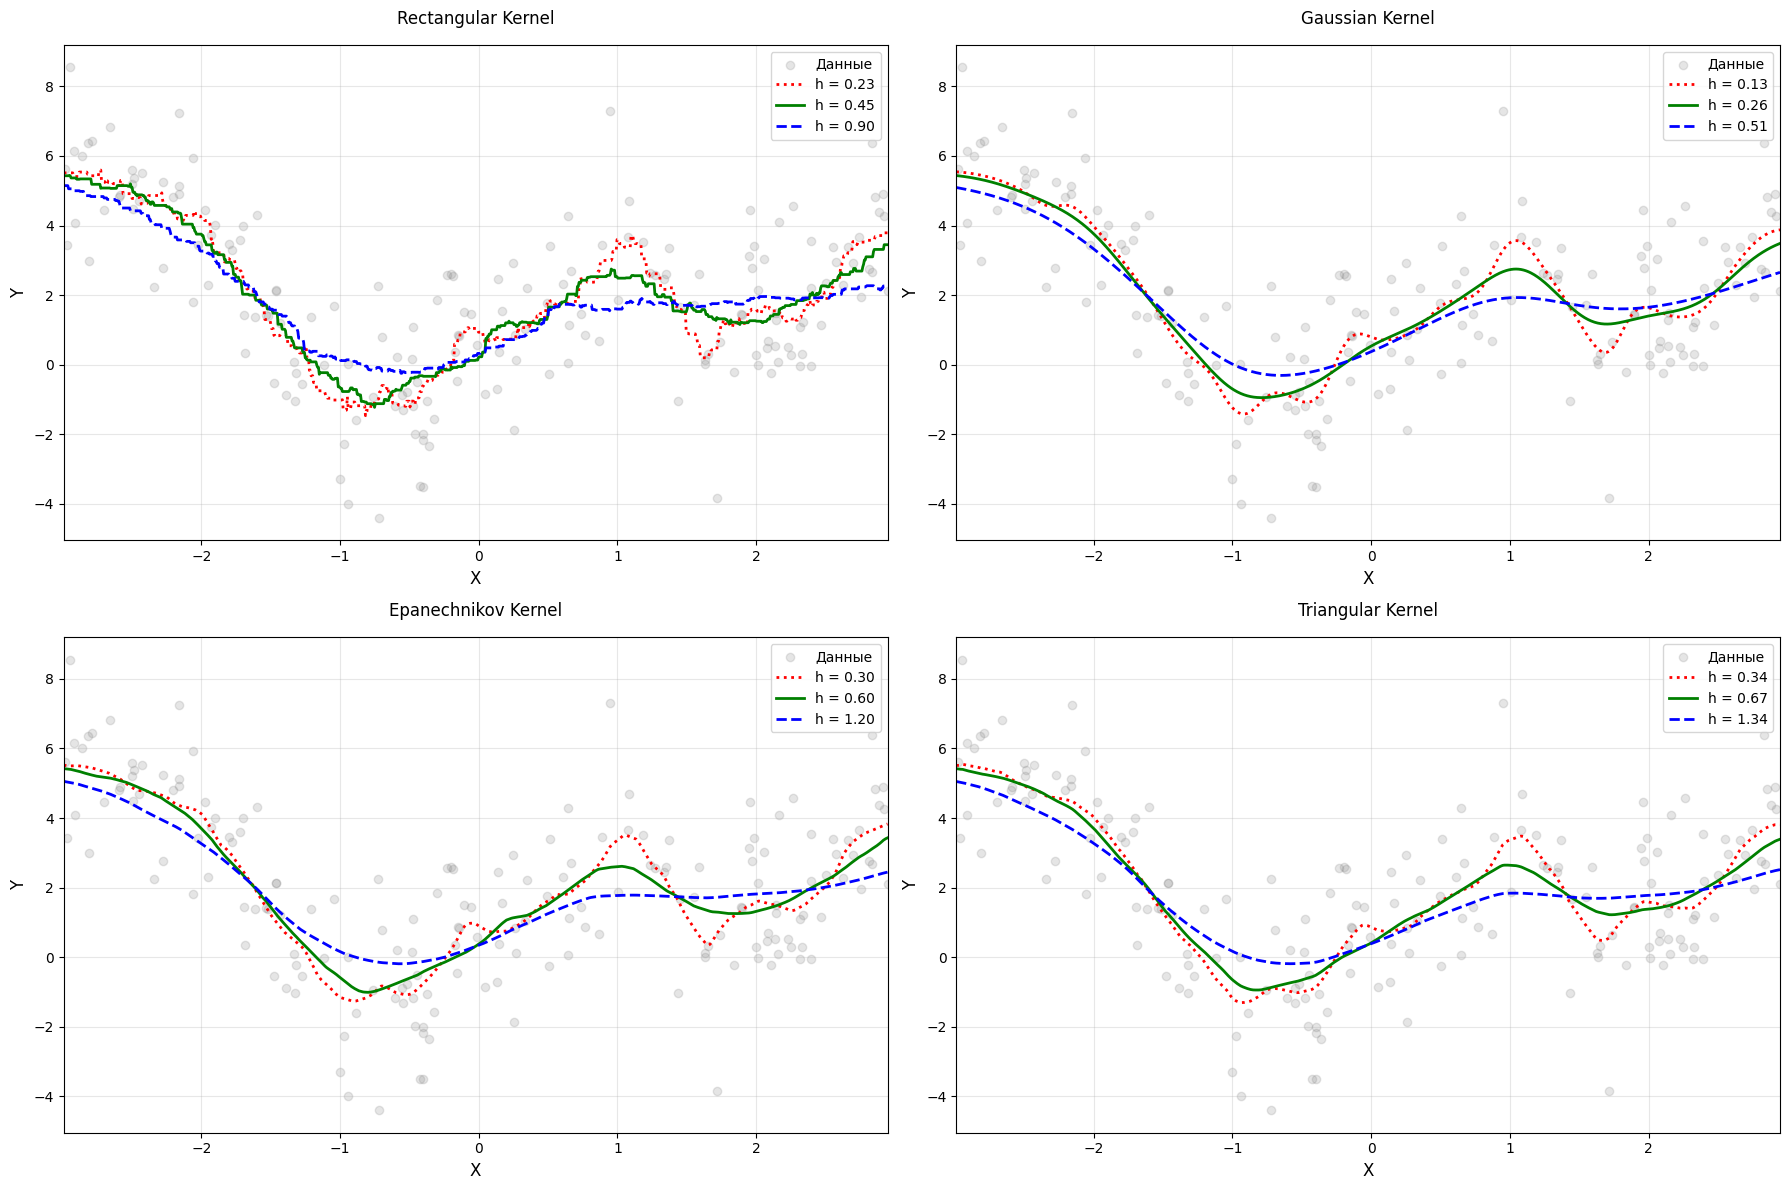

In [85]:
# Оптимальные значения h из задания 2 (для Епанечникова и треугольного окна возьмем h из второго варианта, потому что при слишком
# мелких значениях функция регрессии вообще дискретная получается)
optimal_h = {
    'rectangular': 0.45,
    'gaussian': 0.256,
    'epanechnikov': 0.6,
    'triangular': 0.67
}

x_grid = np.linspace(data.iloc[:,0].min(), data.iloc[:,0].max(), 1000)

plt.figure(figsize=(18, 12))
for i, kernel in enumerate(kernels, 1):
    plt.subplot(2, 2, i)
    
    h_opt = optimal_h[kernel]
    h_values = [0.5*h_opt, h_opt, 2*h_opt]
    colors = ['red', 'green', 'blue']
    styles = [':', '-', '--']
    
    # Исходные данные
    plt.scatter(train_data.iloc[:,0], train_data.iloc[:,1], 
                alpha=0.2, color='gray', label='Данные')
    
    # Регрессия
    for h, color, style in zip(h_values, colors, styles):
        y_pred = kernel_regression(
            train_data.iloc[:,0].values,
            train_data.iloc[:,1].values,
            x_grid,
            h, kernel
        )
        
        plt.plot(x_grid, y_pred, 
                 linewidth=2, 
                 linestyle=style,
                 color=color,
                 label=f'h = {h:.2f}')
    
    # Настройки графика
    plt.title(f'{kernel.capitalize()} Kernel', pad=15)
    plt.xlabel('X', fontsize=12)
    plt.ylabel('Y', fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.xlim(data.iloc[:,0].min(), data.iloc[:,0].max())

plt.tight_layout()
plt.show()

### Выводы

В отношении MSE все виды окон дают примерно одинаковые результаты, но у треугольного окна и окна Епанечникова есть нюанс, что при минимальная MSE на валидационной выборке и на тренировочной может сильно расходиться. 

### Задание 4
Построить  графики зависимости дисперсии и смещения регрессионной модели для 
нескольких фиксированных значений *x* от ширины окна для каждого вида окна из задания 2.

In [ ]:
def calculate_bias_variance(x_point, h, kernel, n_bootstrap=50):
    """Расчет смещения и дисперсии для заданной точки"""
    predictions = []
    
    for _ in range(n_bootstrap):
        # Генерация бутстрап выборки
        bootstrap_sample = train_data.sample(frac=0.8, replace=True)
        
        # Предсказание для целевой точки
        y_pred = kernel_regression(
            bootstrap_sample.iloc[:,0].values,
            bootstrap_sample.iloc[:,1].values,
            np.array([x_point]),
            h, kernel
        )
        predictions.append(y_pred[0])
    
    # Истинное значение (среднее по окрестности)
    y_true = train_data[
        (train_data.iloc[:,0] >= x_point - 0.5*h) & 
        (train_data.iloc[:,0] <= x_point + 0.5*h)
    ].iloc[:,1].mean()
    
    bias_sq = (np.mean(predictions) - y_true)**2
    variance = np.var(predictions)
    
    return bias_sq, variance

In [93]:
x_points = np.percentile(train_data.iloc[:,0], [25, 50, 75])  # 3 фиксированные точки
results = []

for kernel in kernels:
    for h in h_range:
        for x in x_points:
                bias_sq, variance = calculate_bias_variance(x, h, kernel)
                results.append({
                    'kernel': kernel,
                    'h': h,
                    'x': x,
                    'bias_sq': bias_sq,
                    'variance': variance
                })

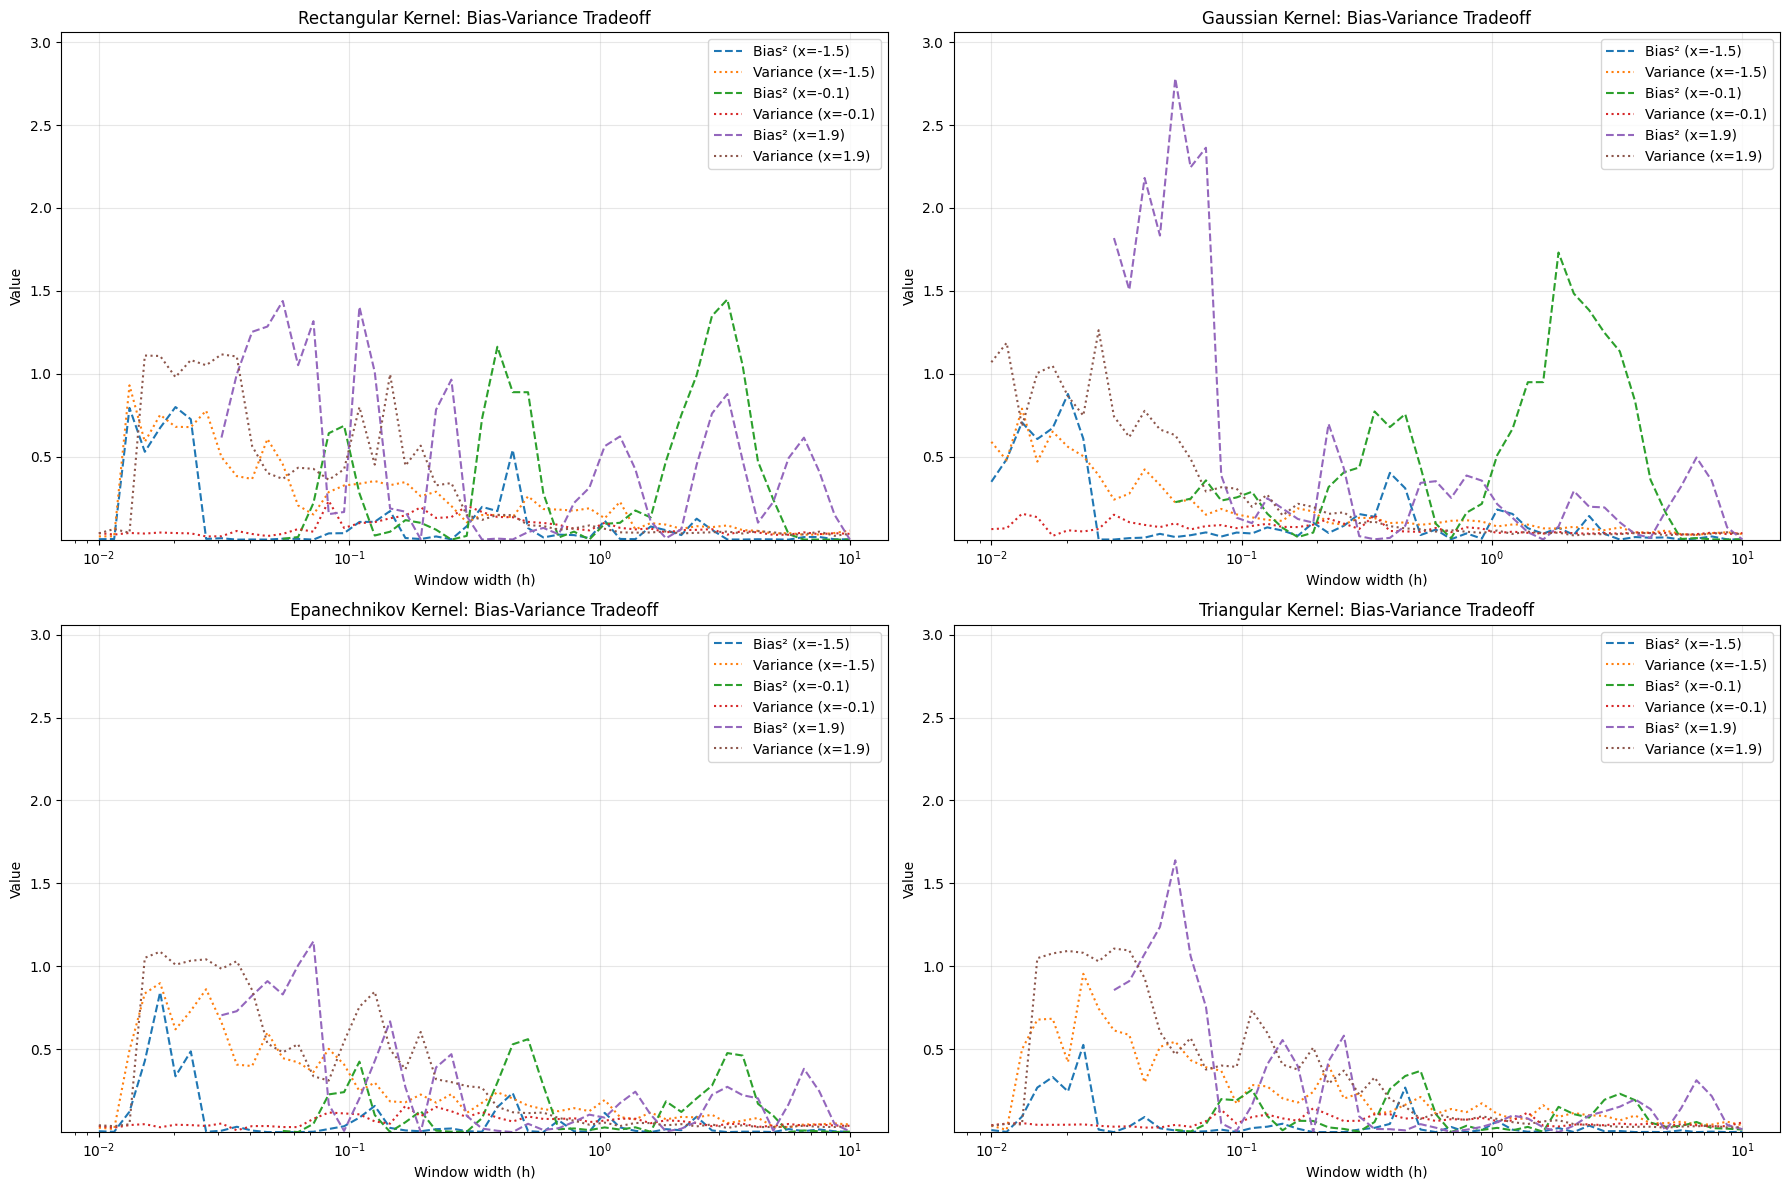

In [ ]:

df_bv = pd.DataFrame(results)
global_min = min(df_bv['bias_sq'].min(), df_bv['variance'].min()) * 0.9
global_max = max(df_bv['bias_sq'].max(), df_bv['variance'].max()) * 1.1

plt.figure(figsize=(18, 12))
for idx, kernel in enumerate(kernels, 1):
    plt.subplot(2, 2, idx)
    subset = df_bv[df_bv['kernel'] == kernel]
    
    for x in x_points:
        x_subset = subset[subset['x'] == x]
        plt.plot(x_subset['h'], x_subset['bias_sq'], 
                 linestyle='--', label=f'Bias² (x={x:.1f})')
        plt.plot(x_subset['h'], x_subset['variance'],
                 linestyle=':', label=f'Variance (x={x:.1f})')
    
    plt.xscale('log')
    plt.ylim(global_min, global_max)
    plt.title(f'{kernel.capitalize()} Kernel: Bias-Variance Tradeoff')
    plt.xlabel('Window width (h)')
    plt.ylabel('Value')
    plt.grid(alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()

### Выводы

При слишком маленьких размерах окна (0.01 -- 0.1) все ядра очень чувствительны к обучающим данным, поскольку у всех большая дисперсия (модель подстраивается под конкретные данные). При больших размерах окна (от 1 выше) variance уходит практически в 0, что говорит о том, что модель стала нечувствительна к обучающим данным (данный факт подтверждается и тем, что в задании 2 графики MSE начинают стремительно расти начиная с размера окна h = 1).

С точки зрения обучаемости лучше себя показывают ядро Епанечникова и треугольное ядро, поскольку их суммарная ошибка стабильно ниже, чем у прямоугольного окна и окна Гаусса, притом что при одинаковых размерах окон у них схожая тенденция скачков дисперсии и смещения. 

### Задание 5
Построить график зависимости MSE KNN-регрессии от числа ближайших соседей K на 
обучающей и тестовой выборках. Определить оптимальное число ближайших соседей и 
визуализировать  графики  KNN-регрессии для различных значений  K:

а) равному оптимальному

б) меньшего оптимального

в) большего оптимального

Оптимальные  значения гиперпараметров обучения  определять по значению ошибки на валидационной выборке.

In [89]:
X_train = train_data.iloc[:, 0].values.reshape(-1, 1)
y_train = train_data.iloc[:, 1].values
X_val = val_data.iloc[:, 0].values.reshape(-1, 1)
y_val = val_data.iloc[:, 1].values
X_test = test_data.iloc[:, 0].values.reshape(-1, 1)
y_test = test_data.iloc[:, 1].values

In [ ]:
k_range = range(1, 51)
results = []

for k in k_range:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)
    
    # Предсказания
    for data_name, (X, y) in zip(
        ['train', 'val', 'test'],
        [(X_train, y_train), (X_val, y_val), (X_test, y_test)]
    ):
        y_pred = model.predict(X)
        mse = mean_squared_error(y, y_pred)
        results.append({
            'k': k,
            'dataset': data_name,
            'mse': mse
        })

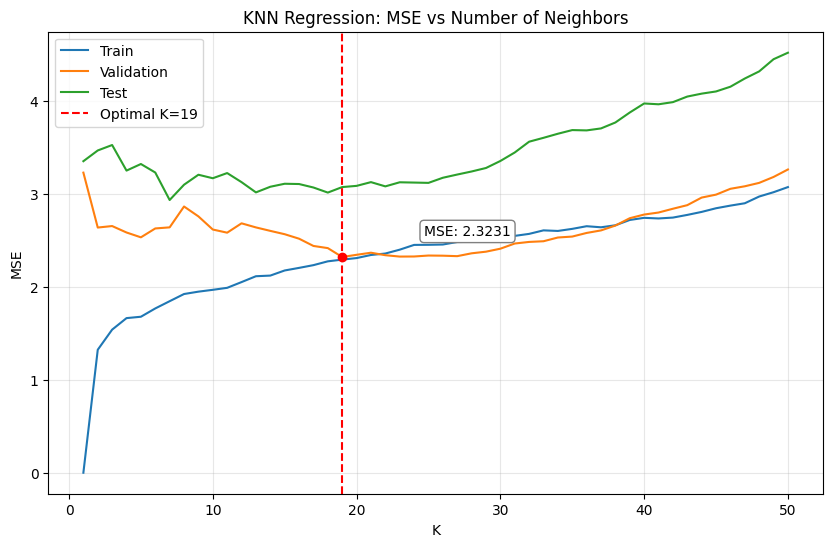

In [91]:
df_results = pd.DataFrame(results)
pivot_results = df_results.pivot(index='k', columns='dataset', values='mse')

plt.figure(figsize=(10, 6))
plt.plot(pivot_results.index, pivot_results['train'], label='Train')
plt.plot(pivot_results.index, pivot_results['val'], label='Validation')
plt.plot(pivot_results.index, pivot_results['test'], label='Test')

# Находим оптимальные значения
optimal_k = pivot_results['val'].idxmin()
optimal_mse = pivot_results.loc[optimal_k, 'val']

# Добавляем аннотацию
plt.scatter(optimal_k, optimal_mse, color='red', zorder=5)
plt.annotate(
    f'MSE: {optimal_mse:.4f}',
    xy=(optimal_k, optimal_mse),
    xytext=(optimal_k*1.3, optimal_mse*1.1),
    bbox=dict(boxstyle="round", fc="white", ec="gray")
)
plt.axvline(pivot_results['val'].idxmin(), color='r', linestyle='--', 
            label=f'Optimal K={pivot_results["val"].idxmin()}')
plt.xlabel('K')
plt.ylabel('MSE')
plt.title('KNN Regression: MSE vs Number of Neighbors')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

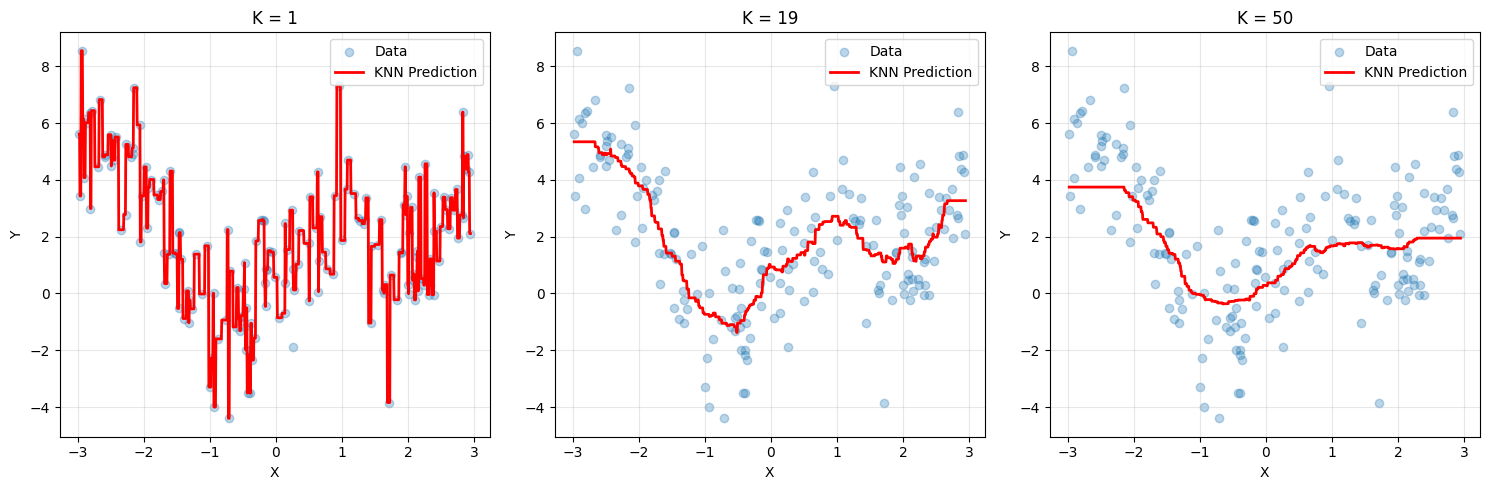

In [ ]:
optimal_k = pivot_results['val'].idxmin()
k_values = [1, optimal_k, 50]

plt.figure(figsize=(15, 5))
for i, k in enumerate(k_values, 1):
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)
    
    x_grid = np.linspace(X_train.min(), X_train.max(), 1000).reshape(-1, 1)
    y_pred = model.predict(x_grid)
    
    plt.subplot(1, 3, i)
    plt.scatter(X_train, y_train, alpha=0.3, label='Data')
    plt.plot(x_grid, y_pred, c='red', linewidth=2, label='KNN Prediction')
    plt.title(f'K = {k}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Выводы

При низком количестве ближайших соседей K функция регрессии становится почти дискретной, и потому малоинформативной. С другой стороны, если К взять слишком большим, то на участке $ 1 < x \leq 2.7$ мы теряем информацию о провале в плотности значений. При оптимальном K = 19 информация о значениях соответствует истине.

### Задание 6
Сделать выводы о влиянии вида и ширины окна на качество ядерной регрессионной модели.